In [1]:
from plot import *

Total cost of FL: 420.781


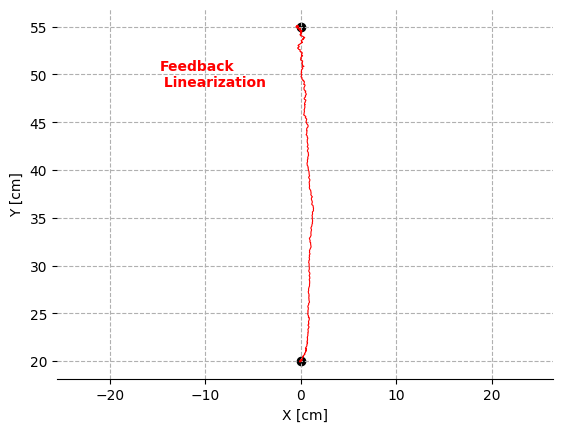

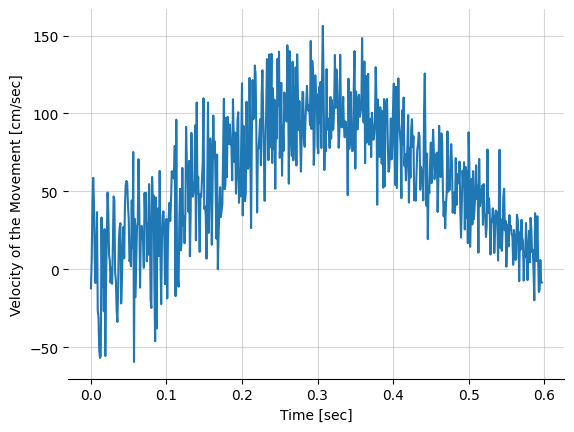

In [2]:
plotFL([0.5,0.5],[0.2,0.2],1e-6)

Total cost of FL: 166.121


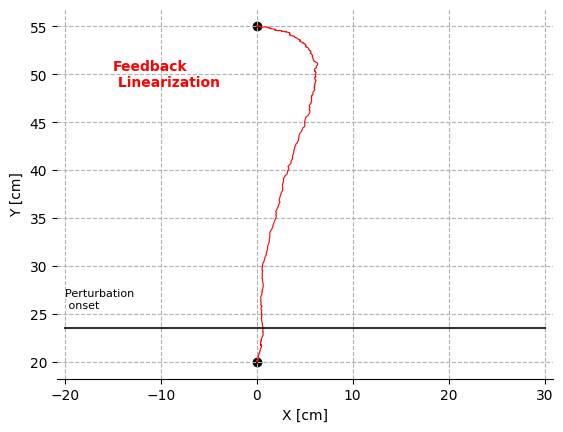

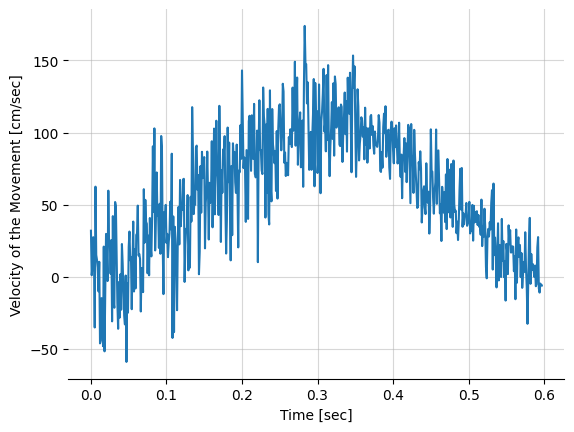

In [3]:
plotFL([-1.5,-0.5],[0.15,0.6],1e-6)

Total cost of LQG : 2905568
Total cost of FL: 41.0989


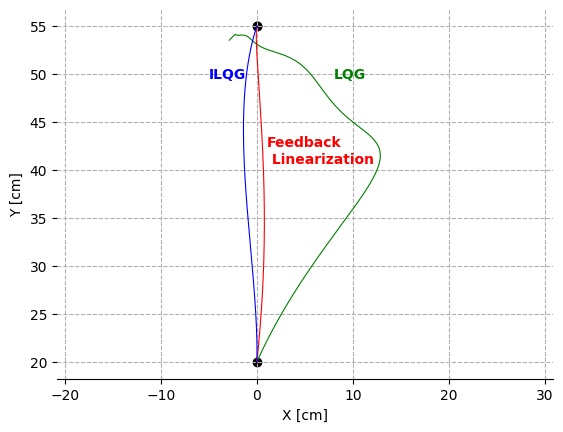

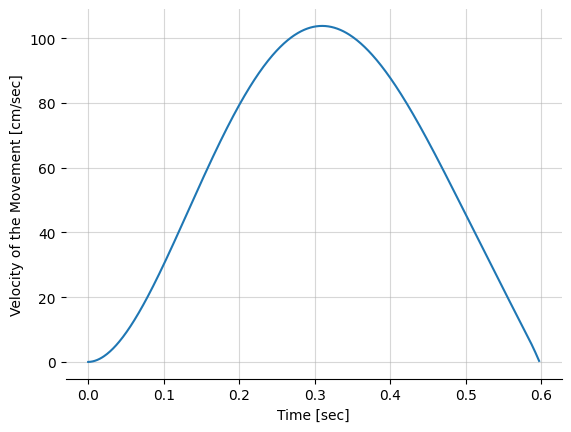

In [4]:
plotSimpleMovements([0.5,0.5],[0.2,0.2],1e-16,K = 4000)

In [5]:
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
my_layout = widgets.Layout()
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout.width = '400px'
@widgets.interact(
    t0 = widgets.FloatSlider(0.2, min=0, max=.6, step=.02, layout=my_layout),
    F1 = widgets.FloatSlider(0.5, min=-5, max=5, step=.1, layout=my_layout),
    F2 = widgets.FloatSlider(0.5, min=-5, max=5, step=.1, layout=my_layout),
)

def test_params(t0 =0.2, F1= 0.5, F2 = 0.5):
    plotSimpleMovements([F1,F2],[t0,0.6],1e-6)

ModuleNotFoundError: No module named 'ipywidgets'